# Benchmarking Agentic RAG: Corrective RAG (CRAG) vs Standard RAG

**Libraries:** `LlamaIndex`, `Arize Phoenix`  
**Dataset:** `HotpotQA (Distractor Split)`

This cookbook demonstrates how to benchmark different RAG architectures using **LlamaIndex Workflows** and **Arize Phoenix**. We will compare a "Standard RAG" baseline against a more advanced "Corrective RAG" (CRAG) agent that can self-correct when retrieval quality is poor.

Using the **HotpotQA** dataset (which requires multi-hop reasoning), we will:
1.  **Ingest Data:** Load a distraction-heavy dataset where only 2 out of 10 retrieved documents are relevant.
2.  **Build Agents:** Create two distinct LlamaIndex Workflows:
    * **Baseline:** A simple retrieve-and-generate pipeline.  Retrieval k=2
    * **Challenger (CRAG):** An agentic workflow that grades its own retrieval and rewrites queries if relevant context is missing.  (2 Experiments, with k=1 and k=2)
3.  **Run Experiments:** Use `phoenix.experiments` to run parallel evaluations on both agents.
4.  **Evaluate:** Use an LLM-as-a-Judge to grade the accuracy of the final answers.


### Prerequisites
* A Google Gemini API Key (or OpenAI/Anthropic equivalent with minor code adjustments).
* Arize Phoenix installed locally.

### Notes

Most of the code was generated by Gemini-pro, with prompting and review by a human.  

### Thanks to team behind Hotpotqa dataset

Link: https://hotpotqa.github.io/






* If all goes well, you should be able to see something like the below dashboard in the last cell.   
* We see that CRAG with k=1 (accuracy: 0.88) is superior to Standard RAG at k=2 (accuracy: 0.76)
* and CRAG with k=2 (accuracy:0.9)
* Hopefully your numbers are similar !

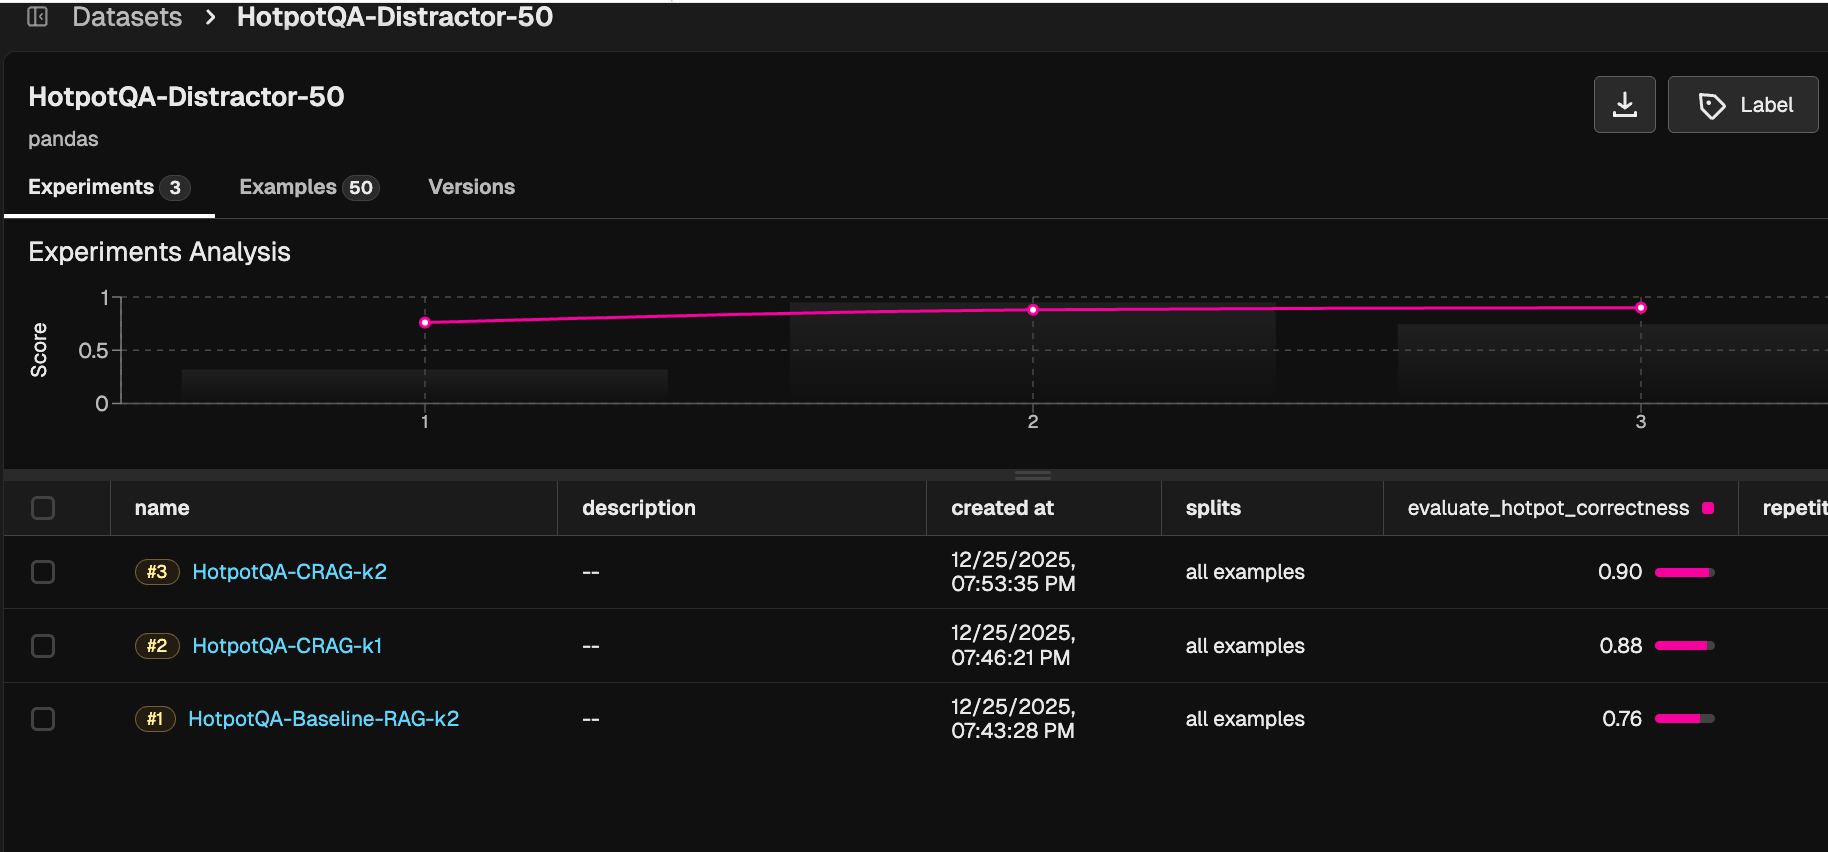


In [ ]:
# Install necessary packages
%%capture
%pip install llama-index
%pip install llama-index-callbacks-arize-phoenix
%pip install llama-index-llms-google-genai llama-index-embeddings-google-genai



In [ ]:
# Install necessary packages
%%capture
%pip install -q arize-phoenix pandas datasets python-dotenv

In [ ]:
%%capture
%pip install nest_asyncio

In [ ]:
import pandas as pd
import asyncio
import os
import nest_asyncio
from dotenv import load_dotenv

# LlamaIndex Imports
from datasets import load_dataset
from llama_index.core import (
    VectorStoreIndex,
    Document,
    Settings,
    set_global_handler,
)
from llama_index.core.workflow import (
    Workflow,
    step,
    StartEvent,
    StopEvent,
    Event,
)
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding

# Phoenix Imports
import phoenix as px
from phoenix.experiments import run_experiment



*   Setting up the Arize Phoenix server

*   You should be able to view the dashboard with session.view().    This is in a later cell.



In [ ]:
# Apply nest_asyncio to allow nested event loops in Jupyter
nest_asyncio.apply()


# Launch Phoenix App
session = px.launch_app()
set_global_handler("arize_phoenix")


print(f"Phoenix launched at: {session.url}")



*   General setup of Keys

*   Configuring Settings (defaults for llama-index)



In [ ]:
# Load environment variables (ensure GEMINI_API_KEY is set in .env or environment)
# Uncomment the next section if you are getting your API key from your environment
# load_dotenv()
# if not os.getenv("GEMINI_API_KEY"):
#    # Fallback for notebook interaction
#    os.environ["GEMINI_API_KEY"] = input("Enter your Google Gemini API Key: ")


# Using Google Colab for key storage:
from google.colab import userdata

# comment the following out if using load_dotenv
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
HF_TOKEN = userdata.get("HF_TOKEN")

os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY
os.environ["HF_TOKEN"] = GEMINI_API_KEY


# Configure Models
Settings.embed_model = GoogleGenAIEmbedding(
    model_name="models/text-embedding-004"
)
Settings.llm = GoogleGenAI(model="models/gemini-2.5-pro", temperature=0.0)

# Separate LLMs for generation vs evaluation
llm = Settings.llm
eval_llm = GoogleGenAI(model="models/gemini-2.5-flash", temperature=0.0)



* Bring in the hotpotqa dataset using the HuggingFace dataset package



In [ ]:
# Load HotpotQA dataset (Distractor Split)
# We take a small slice (first 50 examples) for this demo.
print("Loading HotpotQA dataset (Distractor Split)...")
dataset = load_dataset("hotpot_qa", "distractor", split="validation[:50]")


def process_hotpot_row(row):
    """
    Flattens the HotpotQA 'context' field into a list of strings
    that LlamaIndex can ingest as Documents.
    """
    titles = row["context"]["title"]
    sentences = row["context"]["sentences"]

    documents = []
    for title, sents in zip(titles, sentences):
        text = f"Title: {title}\nContent: {' '.join(sents)}"
        documents.append(text)

    return {
        "question": row["question"],
        "documents": documents,
        "answer": row["answer"],
    }


# Process data and upload to Phoenix for tracking
processed_data = [process_hotpot_row(row) for row in dataset]
experiment_df = pd.DataFrame(processed_data)

experiment_ds = px.Client().upload_dataset(
    dataset_name="HotpotQA-Distractor-50",
    dataframe=experiment_df,
    input_keys=["question", "documents"],
    output_keys=["answer"],
)

print("Dataset uploaded to Phoenix.")

* Function for building a VectorStoreIndex

In [ ]:
def build_index_for_row(documents_list):
    """
    Builds a temporary in-memory VectorStoreIndex for a single row's documents.
    In a production scenario, this would be a connection to a permanent Vector DB.
    """
    docs = [Document(text=d) for d in documents_list]
    return VectorStoreIndex.from_documents(docs)

* class for implementing the Standard RAG workflow.  This is the baseline

In [ ]:
class StandardRagFlow(Workflow):
    """
    A simple Retrieve-and-Generate workflow.
    """

    @step
    async def generate(self, ev: StartEvent) -> StopEvent:
        query = ev.get("question")
        doc_list = ev.get("documents")

        # Capture 'k' from input, default to 2 if missing
        k = ev.get("k", 2)

        # 1. Build Index (Simulates searching a Knowledge Base)
        index = build_index_for_row(doc_list)
        retriever = index.as_retriever(similarity_top_k=k)

        # 2. Retrieve
        nodes = await retriever.aretrieve(query)
        context_str = "\n\n".join([n.get_content() for n in nodes])

        # 3. Generate
        prompt = f"Context: {context_str}\n\nQuestion: {query}\n\nAnswer the question concisely based strictly on the context."
        response = await llm.acomplete(prompt)

        return StopEvent(
            result={
                "answer": str(response),
                "used_context": context_str,
                "source": f"Baseline-Standard-k{k}",
            }
        )


# Helper function to run the Standard RAG workflow
async def run_standard_rag_entry(input_data, k):
    flow = StandardRagFlow(timeout=60, verbose=False)
    return await flow.run(
        question=input_data["question"],
        documents=input_data["documents"],
        k=k,  # Explicitly pass k
    )


* GradeEvent Class for the Event that will be passed between the steps in the CRAG (Corrective Retrieval Augmented Generation).  This is the pipeline state that is passed.
* CragFlow Class is the definition of the CRAG flow.  With a simple orchestion that checks for relevant context and requeries if not relevant.  

In [ ]:
class GradeEvent(Event):
    query: str
    original_context: str
    documents: list
    is_relevant: bool
    k: int


class CragFlow(Workflow):
    """
    Agentic Workflow that grades retrieval quality.
    If irrelevant, it rewrites the query and re-retrieves.
    """

    @step
    async def retrieve(self, ev: StartEvent) -> GradeEvent:
        query = ev.get("question")
        doc_list = ev.get("documents")
        k = ev.get("k", 1)

        # 1. Build Index
        index = build_index_for_row(doc_list)
        retriever = index.as_retriever(similarity_top_k=k)

        # 2. Initial Retrieval
        nodes = await retriever.aretrieve(query)
        context_str = "\n\n".join([n.get_content() for n in nodes])

        # 3. Self-Correction: Grade the Retrieval
        prompt = f"""
        Query: {query}
        Retrieved Context: {context_str}

        Does the context provide ALL the necessary information to answer the query?
        If it's a multi-step question, do we have both steps?
        Answer YES or NO.
        """
        response = await llm.acomplete(prompt)
        is_relevant = "YES" in str(response).upper()

        return GradeEvent(
            query=query,
            original_context=context_str,
            documents=doc_list,
            is_relevant=is_relevant,
            k=k,
        )

    @step
    async def decide_and_generate(self, ev: GradeEvent) -> StopEvent:
        final_context = ev.original_context
        source = f"Local-Standard-k{ev.k}"

        # If retrieval was bad, enter correction loop
        if not ev.is_relevant:
            # 1. Query Rewriting
            rewrite_prompt = f"""
            The original query was: "{ev.query}"
            The retrieved text was: "{ev.original_context[:200]}..."

            Write a NEW, precise search query to find the missing piece of information.
            Output ONLY the query.
            """
            new_query_response = await llm.acomplete(rewrite_prompt)
            new_query = str(new_query_response).strip()

            # 2. Re-Retrieve (Simulating a better search)
            index = build_index_for_row(ev.documents)
            retriever = index.as_retriever(similarity_top_k=ev.k)
            new_nodes = await retriever.aretrieve(new_query)

            # 3. Merge Contexts
            new_context_str = "\n\n".join([n.get_content() for n in new_nodes])
            final_context = f"--- First Search ---\n{ev.original_context}\n\n--- Corrected Search ({new_query}) ---\n{new_context_str}"
            source = f"Local-CRAG-Refined-k{ev.k}"

        # Final Generation
        response = await llm.acomplete(
            f"Question: {ev.query}\nContext: {final_context}\nAnswer:"
        )

        return StopEvent(
            result={
                "answer": str(response),
                "used_context": final_context,
                "source": source,
            }
        )


# Helper function to run the CRAG workflow
async def run_crag_entry(input_data, k):
    flow = CragFlow(timeout=120, verbose=False)
    return await flow.run(
        question=input_data["question"], documents=input_data["documents"], k=k
    )

* Evaluation function for Arize Phoenix that compares the output to the ground_truth

In [ ]:
async def evaluate_hotpot_correctness(
    output: dict, input: dict, expected: dict
) -> float:
    """
    Evaluates if the student's answer matches the ground truth.
    Includes safety checks for failed tasks.
    """
    # 1. Safety Check: Did the task crash? (Returns None if Phoenix failed)
    if output is None:
        return 0.0

    student_answer = output.get("answer", "")
    ground_truth = expected["answer"]
    query = input["question"]

    prompt = f"""
    You are evaluating a Question Answering system on the HotpotQA dataset.

    QUESTION: {query}
    GROUND TRUTH: {ground_truth}
    STUDENT ANSWER: {student_answer}

    Is the student's answer correct?
    HotpotQA answers are often short entities.
    If the student includes the correct entity, mark it correct.

    Return PASS or FAIL.
    """

    # 2. Safety Check: Handle potential Eval LLM failures
    try:
        response = await eval_llm.acomplete(prompt)
        return 1.0 if "PASS" in str(response).upper() else 0.0
    except Exception:
        return 0.0


3 Experiments in the next 3 cells

*   Baseline Standard RAG with k=2

*   Corrective RAG with k=1

*   Corrective RAG with k=2



In [ ]:
# Experiment 1: Baseline RAG with k=2
print("🚀 Running Baseline: Standard RAG (k=2)...")
run_experiment(
    experiment_name="HotpotQA-Baseline-RAG-k2",
    dataset=experiment_ds,
    # Using Lambda to parameterize the task
    task=lambda x: run_standard_rag_entry(x, k=2),
    evaluators=[evaluate_hotpot_correctness],
    dry_run=False,
)

In [ ]:
# Experiment 2: CRAG with k=1
# (Lower k forces the agent to rely on its self-correction capability)
print("\n🚀 Running Challenger: CRAG (k=1)...")
run_experiment(
    experiment_name="HotpotQA-CRAG-k1",
    dataset=experiment_ds,
    task=lambda x: run_crag_entry(x, k=1),
    evaluators=[evaluate_hotpot_correctness],
    dry_run=False,
)

In [ ]:
# Experiment 3: CRAG with k=2
print("\n🚀 Running Challenger: CRAG (k=2)...")
run_experiment(
    experiment_name="HotpotQA-CRAG-k2",
    dataset=experiment_ds,
    task=lambda x: run_crag_entry(x, k=2),
    evaluators=[evaluate_hotpot_correctness],
    dry_run=False,
)

In [ ]:
print(f"\n✅ All Experiments Done! View comparison at: {session.url}")

session.view()
# click on Datasets&Experiments in the left pane, then click on Experiment comparisons